In [1]:
import itertools
import os
import pathlib
import random
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt, image as mpimg
import pandas as pd
from difficulty_levels import DifficultyLevels
from tensorflow import keras
import tensorflow as tf
from typing import Optional
from tensorflow.python.keras.callbacks import ModelCheckpoint


download_folder = "tracking_data_download"
labeled_images_folder = "labeled_images"

RANDOM_SEED = 42
NUMBER_OF_CLASSES = 3

results_folder = "ml_results"
data_folder_path = os.path.join("..", "post_processing", download_folder)

NEW_IMAGE_SIZE = (128, 128)

In [2]:
def split_train_test(participant_list, train_ratio=0.8):
    random.shuffle(participant_list)

    train_split = int(len(participant_list) * train_ratio)
    train_participants = participant_list[:train_split]
    test_participants = participant_list[train_split:]
    print(f"{len(train_participants)} participants used for training: {train_participants}")
    print(f"{len(test_participants)} participants used for validation: {test_participants}")

    return train_participants, test_participants

def set_random_seed(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def show_result_plot(train_history, epochs, metric="categorical_accuracy", output_folder=results_folder,
                     output_name="train_history.png"):

    acc = train_history.history[f"{metric}"]
    val_acc = train_history.history[f"val_{metric}"]
    loss = train_history.history["loss"]
    val_loss = train_history.history["val_loss"]

    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # save plot to file and show in a new window
    plt.savefig(os.path.join(output_folder, output_name))
    plt.show()

In [10]:
def merge_participant_image_logs(participant_list):
    image_data_frame = pd.DataFrame()
    post_processing_folder_path = os.path.join("..", "post_processing")

    for participant in participant_list:
        images_label_log = os.path.join(post_processing_folder_path,  download_folder, participant, "labeled_images.csv")
        # images_label_log = os.path.join(post_processing_folder_path, download_folder, participant, "labeled_eye_regions.csv")
        labeled_images_df = pd.read_csv(images_label_log)

        difficulty_level_df = pd.DataFrame()
        for difficulty_level in labeled_images_df.difficulty.unique():
            # create a subset of the df that contains only the rows with this difficulty level
            sub_df = labeled_images_df[labeled_images_df.difficulty == difficulty_level]
            sub_df = sub_df[:250]
            difficulty_level_df = pd.concat([difficulty_level_df, sub_df])

        image_data_frame = pd.concat([image_data_frame, difficulty_level_df])

    # add the index numbers as own column (reset the index first as the concatenate above creates duplicate indexes)
    image_data_frame_numbered = image_data_frame.reset_index(drop=True)
    image_data_frame_numbered["index"] = image_data_frame_numbered.index

    return image_data_frame_numbered

In [4]:
def show_generator_example_images_gen_v2(sample, labels):
    sample_len = len(sample)
    length = min(100, sample_len)  # show 100 images or sample length if samples has less images

    plt.figure(figsize=(50, 50))
    for i in range(length):
        plt.subplot(10, 10, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        # plt.imshow(sample[i][0:500, :, :])
        plt.imshow(sample[i][:, 0:1500, :])  # if width instead of height 
        plt.title(DifficultyLevels.get_label_for_encoding(labels[i]))
    plt.show()

In [5]:
def show_generator_example_images_gen(sample, labels):
    for j, image in enumerate(range(len(sample))):
        sample_len = len(sample[j])
        length = min(100, sample_len)  # show 100 images or sample length if samples has less images

        plt.figure(figsize=(15, 10))
        for i in range(length):
            plt.subplot(10, 10, i + 1)
            plt.grid(False)
            plt.imshow(sample[j][i])  # , cmap=plt.cm.binary)
            plt.xlabel(labels[j])
            # plt.axis('off')
        plt.show()

In [6]:
class CustomImageDataGenerator(tf.keras.utils.Sequence):
    """
    Structure based on https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """

    def __init__(self, data_frame, x_col_name, y_col_name, sample_size, batch_size, num_classes=3,
                 images_base_path=".", use_grayscale=False):

        self.df = data_frame.copy()
        self.X_col = x_col_name
        self.y_col = y_col_name
        self.batch_size = batch_size
        self.sequence_length = sample_size
        self.n_classes = num_classes
        self.images_base_path = images_base_path
        self.use_grayscale = use_grayscale

        self.n = len(self.df)

        num_channels = 1 if self.use_grayscale else 3
        self.output_size = (*NEW_IMAGE_SIZE, num_channels)
        
        # self.new_image_shape = (self.output_size[0], (self.sequence_length * self.output_size[1]), self.output_size[2])

        # create a random order for the samples
        self.indices_list = self.generate_random_index_list()

    def generate_random_index_list(self):
        sample_indices = []
        for i in range(0, self.n, self.sequence_length):
            sample_indices.append(i)

        random.shuffle(sample_indices)
        return sample_indices

    def __len__(self):
        length = self.n // (self.sequence_length * self.batch_size)
        return length

    def on_epoch_end(self):
        self.indices_list = self.generate_random_index_list()  # each epoch we generate a new indices order
        
    def __getitem__(self, index):
        X = np.empty((self.batch_size, self.sequence_length, *self.output_size), dtype=np.float32)
        y = np.empty((self.batch_size, self.n_classes))

        for i, batch in enumerate(range(self.batch_size)):
            if len(self.indices_list) == 0:
                continue

            # Get a random index from the list
            start_index = random.choice(self.indices_list)
            # and remove this index from the list so it won't be used more than once per epoch
            self.indices_list.remove(start_index)

            sample_rows = self.df[start_index:start_index + self.sequence_length]  # get the corresponding df rows
            image_sample, sample_label = self.__get_data(sample_rows)

            X[i, ] = image_sample
            y[i, ] = sample_label

        return X, y


    def __get_data(self, sample):
        image_sample = np.empty((self.sequence_length, *self.output_size), dtype=np.float32)

        # Load and preprocess the images for the current sample
        i = 0
        for idx, row in sample.iterrows():
            img_path = row[self.X_col]
            image_path = os.path.join(self.images_base_path, img_path)
            image_sample[i, ] = self.__scale_and_convert_image(image_path)  # load image and resize and scale it
            i += 1

        label = sample[self.y_col].iloc[0]  # take the label of the first element in the sample
        sample_label = DifficultyLevels.get_one_hot_encoding(label)  # convert string label to one-hot-vector

        return image_sample, sample_label

    def crop_center_square(self, frame):
        y, x = frame.shape[0:2]
        min_dim = min(y, x)
        start_x = (x // 2) - (min_dim // 2)
        start_y = (y // 2) - (min_dim // 2)
        cropped_frame = frame[start_y: start_y + min_dim, start_x: start_x + min_dim]
        resized_img = tf.image.resize_with_pad(cropped_frame,
                                               target_height=NEW_IMAGE_SIZE[0],
                                               target_width=NEW_IMAGE_SIZE[1])
        return resized_img

    def __scale_and_convert_image(self, image_path):
        try:
            color_mode = "grayscale" if self.use_grayscale else "rgb"

            image = tf.keras.preprocessing.image.load_img(image_path, color_mode=color_mode)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            # crop or pad image depending on it's size
            """
            resized_img = tf.image.resize_with_crop_or_pad(image_arr,
                                                           target_height=NEW_IMAGE_SIZE[0],
                                                           target_width=NEW_IMAGE_SIZE[1])
            """
            resized_img = self.crop_center_square(image_arr)
            # normalize pixel values to [0, 1] so the ml model can work with smaller values
            # scaled_img = resized_img.numpy() / 255.0
            scaled_img = resized_img / 255.0
            return scaled_img

        except Exception as e:
            sys.stderr.write(f"\nError in processing image '{image_path}': {e}")
            return None

    def get_image_shape(self):
        return self.batch_size, self.sequence_length, *self.output_size
    
    def get_example_batch(self, idx=0):
        # we need to make a copy first so we don't actually change the list by taking an example
        indices_copy = self.indices_list.copy()
        first_sample, labels = self.__getitem__(idx)
        self.indices_list = indices_copy
        return first_sample, labels

In [7]:
def start_preprocessing(model_version=1):
    set_random_seed()  # set seed for reproducibility

    without_participants = []
    all_participants = os.listdir(data_folder_path)[:12]
    all_participants = [p for p in all_participants if p not in set(without_participants)]

    train_participants, test_participants = split_train_test(all_participants)

    train_data = merge_participant_image_logs(train_participants)
    val_data = merge_participant_image_logs(test_participants)

    # See https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network for consequences of
    # the batch size. Smaller batches lead to better results in general. Batch sizes are usually a power of two.
    batch_size = 3
    sample_size = 25
    train_epochs = 32
    use_gray = False
    
    print(f"Train Data len: {len(train_data)})")
    print(f"Validation Data len: {len(val_data)})")

    images_path = os.path.join("..", "post_processing")

    train_generator = CustomImageDataGenerator(data_frame=train_data, x_col_name="image_path", y_col_name="difficulty",
                                               sample_size=sample_size, batch_size=batch_size,
                                               images_base_path=images_path, use_grayscale=use_gray)

    val_generator = CustomImageDataGenerator(data_frame=val_data, x_col_name="image_path", y_col_name="difficulty",
                                             sample_size=sample_size, batch_size=batch_size,
                                             images_base_path=images_path, use_grayscale=use_gray)

    # show some example train images to verify the generator is working correctly
    print("Batch 1:")
    sample, sample_labels = train_generator.get_example_batch()
    show_generator_example_images_gen(sample, sample_labels)
    # print("Batch 2:")
    # sample, sample_labels = train_generator.get_example_batch(idx=1)
    # show_generator_example_images_gen(sample, sample_labels)

    print("Len train generator: ", train_generator.__len__())
    print("Len val generator: ", val_generator.__len__())

    image_shape = train_generator.get_image_shape()
    print("Image Shape: ", image_shape)

    classifier = DifficultyImageClassifier(num_classes=NUMBER_OF_CLASSES, num_epochs=train_epochs)

    if model_version == 1:
        classifier.build_model(input_shape=image_shape)
    elif model_version == 2:
        classifier.build_model_2(input_shape=image_shape)
    elif model_version == 3:
        classifier.build_model_3(input_shape=image_shape)

    classifier.train_classifier(train_generator, val_generator)
    classifier.evaluate_classifier()

In [8]:
class DifficultyImageClassifier:
    """
    Custom CNN for predicting the difficulty level with images of a user's face.
    """

    def __init__(self, num_classes, num_epochs=32):
        self.n_classes = num_classes
        self.n_epochs = num_epochs
        self.num_workers = 8

    def build_model(self, input_shape) -> tf.keras.Model:
        print(input_shape)        
        self.sequential_model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=input_shape[1:]),
                tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")),
                # if stateful = True, use this:
                #tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"), 
                #                                batch_input_shape=input_shape),
                tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2)),
                tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")),
                tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2)),
                tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")),
                tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2)),
    
                tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
                
                #tf.keras.layers.LSTM(50, stateful=False, return_sequences=True),
                #tf.keras.layers.LSTM(10, stateful=False),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.LSTM(256, stateful=False, return_sequences=False, dropout=0.5),

                # tf.keras.layers.Dense(128),
                tf.keras.layers.Dense(units=self.n_classes, activation="softmax")
            ]
        )

        self.sequential_model.summary()
        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])

        return self.sequential_model
    
    def build_model_2(self, input_shape) -> tf.keras.Model:
        # with padding="same"
        
        print(input_shape)        
        self.sequential_model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=input_shape[1:]),
                tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")),
                # if stateful = True, use this:
                #tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"), 
                #                                batch_input_shape=input_shape),
                tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2)),
                tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")),
                tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2)),
                tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")),
                tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2)),
    
                tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
                
                #tf.keras.layers.LSTM(50, stateful=False, return_sequences=True),
                #tf.keras.layers.LSTM(10, stateful=False),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.LSTM(256, stateful=False, return_sequences=False, dropout=0.5),

                # tf.keras.layers.Dense(128),
                tf.keras.layers.Dense(units=self.n_classes, activation="softmax")
            ]
        )

        self.sequential_model.summary()
        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])

        return self.sequential_model
    
    def build_model_3(self, input_shape) -> tf.keras.Model:
        # with stateful=True
        
        print(input_shape)        
        self.sequential_model = tf.keras.Sequential(
            [
                tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                                                batch_input_shape=input_shape),
                tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2)),
                tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")),
                tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2)),
                tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")),
                tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2)),
    
                tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
                
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.LSTM(256, stateful=True, return_sequences=True, dropout=0.5),
                tf.keras.layers.LSTM(10, stateful=True),

                # tf.keras.layers.Dense(128),
                tf.keras.layers.Dense(units=self.n_classes, activation="softmax")
            ]
        )

        self.sequential_model.summary()
        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])

        return self.sequential_model

    def train_classifier(self, train_generator, val_generator):
        print("Using TimeDistributedLayers ...")
        
        self.train_generator = train_generator
        self.validation_generator = val_generator

        #self.step_size_train = train_generator.n // (train_generator.sample_size * train_generator.batch_size)
        #self.step_size_val = val_generator.n // (val_generator.sample_size * val_generator.batch_size)

        model_name = "Difficulty-Time-Series-Model-Generator.h5"
        model_path = os.path.join(results_folder, model_name)

        checkpoint_path = os.path.join(results_folder, "time_series_checkpoints_generator",
                                       "checkpoint-improvement-{epoch:02d}-{val_categorical_accuracy:.3f}.ckpt")
        # save checkpoints
        checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_categorical_accuracy', verbose=1,
                                              mode="max", save_best_only=True, save_weights_only=True)
        lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

        history = self.sequential_model.fit(self.train_generator,
                                            validation_data=self.validation_generator,
                                            # shuffle=False,
                                            # use_multiprocessing=False,
                                            workers=self.num_workers,
                                            epochs=self.n_epochs,
                                            callbacks=[lr_callback],
                                            verbose=1)

        # self.sequential_model.save(model_path)
        show_result_plot(history, self.n_epochs, metric="categorical_accuracy",
                         output_name="train_history_time_series.png")

        return history

    def evaluate_classifier(self):
        val_loss, val_acc = self.sequential_model.evaluate(self.validation_generator,
                                                           verbose=1)
        print("Validation loss: ", val_loss)
        print("Validation accuracy: ", val_acc * 100)

In [8]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # use cpu instead of gpu

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
if len(gpus) == 0:
    print("No gpu found!")
else:
    print("Using gpu ...")
    # tf.config.experimental.set_memory_growth(gpus[0], True)

Name: /physical_device:GPU:0   Type: GPU
Using gpu ...


In [ ]:
start_preprocessing(1)

In [ ]:
start_preprocessing(2)

In [ ]:
start_preprocessing(3)

In [10]:
class DifficultyImageClassifier:
    """
    Custom CNN for predicting the difficulty level with images of a user's face.
    """

    def __init__(self, num_classes, num_epochs=32):
        self.n_classes = num_classes
        self.n_epochs = num_epochs
        self.num_workers = 8

    """
    def build_model(self, input_shape) -> tf.keras.Model:
        # see http://francescopochetti.com/video-classification-in-keras-a-couple-of-approaches/
        print("Using Conv3D...")

        self.sequential_model = tf.keras.Sequential()
        self.sequential_model.add(tf.keras.layers.Conv3D(32, (3,3,3), activation='relu', input_shape=(input_shape[1:])))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        self.sequential_model.add(tf.keras.layers.Conv3D(64, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        self.sequential_model.add(tf.keras.layers.Conv3D(256, (2,2,2), activation='relu'))
        self.sequential_model.add(tf.keras.layers.Conv3D(256, (2,2,2), activation='relu'))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

        self.sequential_model.add(tf.keras.layers.Flatten())
        self.sequential_model.add(tf.keras.layers.Dense(1024, activation='relu'))
        # self.sequential_model.add(tf.keras.layers.Dropout(0.5))
        self.sequential_model.add(tf.keras.layers.Dropout(0.2))
        self.sequential_model.add(tf.keras.layers.Dense(3, activation='softmax'))

        self.sequential_model.summary()
        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])

        return self.sequential_model
    """
    
    def build_model(self, input_shape) -> tf.keras.Model:
        # based on https://keras.io/examples/vision/3D_image_classification/#define-a-3d-convolutional-neural-network
        print("Using Conv3D...")

        self.sequential_model = tf.keras.Sequential()
        self.sequential_model.add(tf.keras.layers.Conv3D(64, (3,3,3), activation='relu', input_shape=(input_shape[1:])))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
        self.sequential_model.add(tf.keras.layers.BatchNormalization())
        
        self.sequential_model.add(tf.keras.layers.Conv3D(64, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
        self.sequential_model.add(tf.keras.layers.BatchNormalization())
        
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
        self.sequential_model.add(tf.keras.layers.BatchNormalization())
        
        self.sequential_model.add(tf.keras.layers.Conv3D(256, (2,2,2), activation='relu'))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
        self.sequential_model.add(tf.keras.layers.BatchNormalization())

        self.sequential_model.add(tf.keras.layers.GlobalAveragePooling3D())
        self.sequential_model.add(tf.keras.layers.Dense(units=512, activation='relu'))
        # self.sequential_model.add(tf.keras.layers.Dropout(0.2))
        self.sequential_model.add(tf.keras.layers.Dense(3, activation='softmax'))

        self.sequential_model.summary()

        initial_learning_rate = 0.0001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
        )
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        # self.sequential_model.compile(optimizer=opt,
        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])

        return self.sequential_model

    def train_classifier(self, train_generator, val_generator):
        self.train_generator = train_generator
        self.validation_generator = val_generator

        lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

        history = self.sequential_model.fit(self.train_generator,
                                            validation_data=self.validation_generator,
                                            #shuffle=False,
                                            use_multiprocessing=False,
                                            workers=self.num_workers,
                                            epochs=self.n_epochs,
                                            callbacks=[lr_callback],
                                            verbose=1)

        show_result_plot(history, self.n_epochs, metric="categorical_accuracy",
                         output_name="train_history_time_series.png")

        return history

    def evaluate_classifier(self):
        val_loss, val_acc = self.sequential_model.evaluate(self.validation_generator,
                                                           verbose=1)
        print("Validation loss: ", val_loss)
        print("Validation accuracy: ", val_acc * 100)

In [ ]:
start_preprocessing()

In [11]:
# see https://keras.io/examples/vision/conv_lstm/
class DifficultyImageClassifier:
    """
    Custom CNN for predicting the difficulty level with images of a user's face.
    """

    def __init__(self, num_classes, num_epochs=32):
        self.n_classes = num_classes
        self.n_epochs = num_epochs
        self.num_workers = 8

    """
    def build_model(self, input_shape):
        print("Using ConvLSTM2D...")
        
        # Model architecture based on https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7
        image_input  = tf.keras.Input(shape=input_shape[1:], name='image_input')

        first_ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=20, kernel_size=(3, 3), recurrent_activation='hard_sigmoid', activation='tanh', 
                                    padding='same', return_sequences=True)(image_input)
        first_BatchNormalization = tf.keras.layers.BatchNormalization()(first_ConvLSTM)
        first_Pooling = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same')(first_BatchNormalization)

        second_ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=10, kernel_size=(3, 3), padding='same', return_sequences=True)(first_Pooling)
        second_BatchNormalization = tf.keras.layers.BatchNormalization()(second_ConvLSTM)
        second_Pooling = tf.keras.layers.MaxPooling3D(pool_size=(1, 3, 3), padding='same')(second_BatchNormalization)

        outputs = [self.branch(second_Pooling, f'cat_{category}') for category in DifficultyLevels.values()]
        # combinedOutput = tf.keras.layers.concatenate(outputs)
        # print("combinedOutput: ", combinedOutput)
        #output = tf.keras.layers.Dense(self.n_classes, activation='softmax')(combinedOutput)

        self.sequential_model = tf.keras.Model(inputs=image_input, outputs=combinedOutput, name='ConvLSTM2D_Model')
        self.sequential_model.summary()

        # TODO not working as we have only binary now! labels should be binary instead of vectors as well now
        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["accuracy"])
        return self.sequential_model

    def branch(self, last_convlstm_layer, name):

        branch_ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=5, kernel_size=(3, 3), stateful = False, kernel_initializer='random_uniform',
                                     padding='same', return_sequences=True)(last_convlstm_layer)
        branch_Pooling = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same')(branch_ConvLSTM)
        flat_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(branch_Pooling)

        first_Dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256,))(flat_layer)
        second_Dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32,))(first_Dense)
        target = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1), name=name)(second_Dense)
        # target = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.n_classes, activation='softmax', name=name))(second_Dense)
        return target
    """

    def build_model(self, input_shape):
        print("Using ConvLSTM2D...")
        
        # Model architecture based on https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7
        image_input  = tf.keras.Input(shape=input_shape[1:], name='image_input')

        first_ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=20, kernel_size=(3, 3), recurrent_activation='hard_sigmoid', activation='tanh', 
                                    padding='same', return_sequences=True)(image_input)
        first_BatchNormalization = tf.keras.layers.BatchNormalization()(first_ConvLSTM)
        first_Pooling = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same')(first_BatchNormalization)

        second_ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=10, kernel_size=(3, 3), padding='same', return_sequences=True)(first_Pooling)
        second_BatchNormalization = tf.keras.layers.BatchNormalization()(second_ConvLSTM)
        second_Pooling = tf.keras.layers.MaxPooling3D(pool_size=(1, 3, 3), padding='same')(second_BatchNormalization)

        third_ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=5, kernel_size=(3, 3), stateful = False, kernel_initializer='random_uniform',
                                     padding='same', return_sequences=True)(second_Pooling)
        branch_Pooling = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same')(third_ConvLSTM)
        flat_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(branch_Pooling)

        # tf.keras.layers.LSTM(256, stateful=True, return_sequences=True, dropout=0.5),
        first_Dense = tf.keras.layers.Dense(256)(flat_layer)
        dropout = tf.keras.layers.Dropout(0.3)(first_Dense)
        # second_Dense = tf.keras.layers.Dense(32,)(first_Dense)
        flat2 = tf.keras.layers.Flatten()(dropout)  # => 45 %
        target = tf.keras.layers.Dense(self.n_classes, activation='softmax')(flat2)
        
        
        self.sequential_model = tf.keras.Model(inputs=image_input, outputs=target, name='ConvLSTM2D_Model')
        self.sequential_model.summary()

        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])
        return self.sequential_model


    """
    def build_model(self, input_shape) -> tf.keras.Model:
        print("Using ConvLSTM2D...")

        self.sequential_model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=input_shape[1:]),
                tf.keras.layers.ConvLSTM2D(20, (3, 3), padding='same', return_sequences=True, activation="relu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'),
                tf.keras.layers.ConvLSTM2D(10, (3, 3), padding='same', return_sequences=True, activation="relu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'),
                tf.keras.layers.ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True, activation="relu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'),
                
                # tf.keras.layers.Conv2D(3, (3, 3), padding='same'),
                # TODO remove this layer?
                # tf.keras.layers.Conv3D(filters=self.n_classes, kernel_size=(3, 3, 3), activation="softmax", padding="same"),

                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(units=self.n_classes, activation="softmax")
            ]
        )

        self.sequential_model.summary()
        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])

        return self.sequential_model
    """

    def train_classifier(self, train_generator, val_generator):
        self.train_generator = train_generator
        self.validation_generator = val_generator

        lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

        history = self.sequential_model.fit(self.train_generator,
                                            validation_data=self.validation_generator,
                                            shuffle=False,
                                            use_multiprocessing=False,
                                            workers=self.num_workers,
                                            epochs=self.n_epochs,
                                            initial_epoch=0,
                                            callbacks=[lr_callback],
                                            verbose=1)

        model_path = os.path.join(results_folder, "Difficulty-CNN-TimeSeries-ConvLSTM.h5")
        self.sequential_model.save(model_path)

        show_result_plot(history, self.n_epochs, metric="categorical_accuracy",
                         output_name="train_history_time_series.png")

        return history

    def evaluate_classifier(self):
        val_loss, val_acc = self.sequential_model.evaluate(self.validation_generator,
                                                           verbose=1)
        print("Validation loss: ", val_loss)
        print("Validation accuracy: ", val_acc * 100)
    
    def load_saved_model(self):
        model_name = "Difficulty-CNN-TimeSeries-ConvLSTM.h5"
        model_path = os.path.join(results_folder, model_name)

        if os.path.exists(model_path):
            loaded_model = tf.keras.models.load_model(model_path)
            print("Model successfully loaded")
            return loaded_model
        else:
            sys.stderr.write("No saved model found!")
            return None

    def save_prediction_as_image(self, batch, sequence_number, actual_label, predicted_label, use_dataset=False):
        sequence = batch[sequence_number]
        sequence_len = int(sequence.shape[1] / sequence.shape[0])   # calculate the sequence length based on the shape
        img_height, img_width = NEW_IMAGE_SIZE

        plt.figure(figsize=(10, 10))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(sequence[:, 0:sequence_len * img_width, :])
        plt.ylabel(DifficultyLevels.get_label_for_encoding(actual_label))
        plt.title(f"Predicted label: {predicted_label}")

        plt.show()

    def get_label_name_for_index_pos(self, index_pos):
        mask_array = np.zeros(self.n_classes, dtype=int)  # creates this: [0 0 0]
        mask_array[index_pos] = 1  # if index_pos was 0: [1 0 0]
        return DifficultyLevels.get_label_for_encoding(mask_array)

    def predict(self, img_batch, correct_labels):
        """
        # load latest (i.e. the best) checkpoint
        loaded_model = self.load_saved_model(dataset_version=False)  # re-create the model first!
        # checkpoint_folder = os.path.join(results_folder, "checkpoints_generator")  # "checkpoints_dataset"

        # latest = tf.train.latest_checkpoint(checkpoint_folder)
        # loaded_model.load_weights(latest)
        """

        # or like this:
        # loaded_model.load_weights("Difficulty-CNN-TimeSeries-ConvLSTM.h5")

        predictions = self.sequential_model.predict(img_batch)

        for i, (prediction, correct_label) in enumerate(zip(predictions, correct_labels)):
            score = tf.nn.softmax(prediction)  # TODO use this or prediction?
            print(f"\nPrediction for sequence {i}: {prediction}\nScore: {score})")
            index = np.argmax(score)
            predicted_label = self.get_label_name_for_index_pos(index)
            print(f"Correct label is  \"{DifficultyLevels.get_label_for_encoding(correct_label)}\"")
            print(f"Predicted label was \"{predicted_label}\" with a confidence of {100 * score[index]:.2f} %")

            self.save_prediction_as_image(img_batch, i, correct_label, predicted_label, use_dataset=False)

9 participants used for training: ['participant_3', 'participant_14', 'participant_11', 'participant_4', 'participant_5', 'participant_2', 'participant_7', 'participant_12', 'participant_13']
3 participants used for validation: ['participant_1', 'participant_10', 'participant_6']
Train Data len: 6750)
Validation Data len: 2250)
Batch 1:


c:\users\nutzer\appdata\local\programs\python\python39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


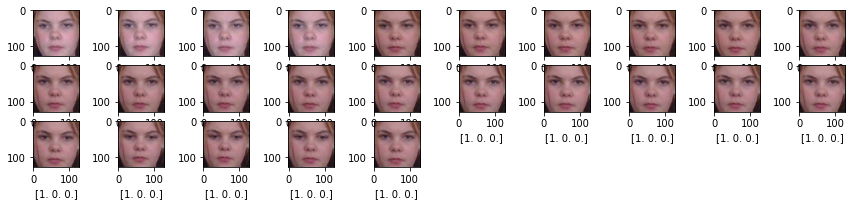

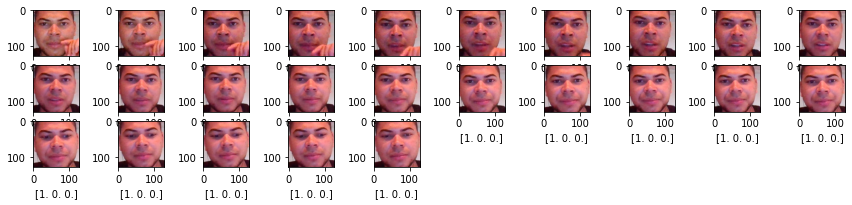

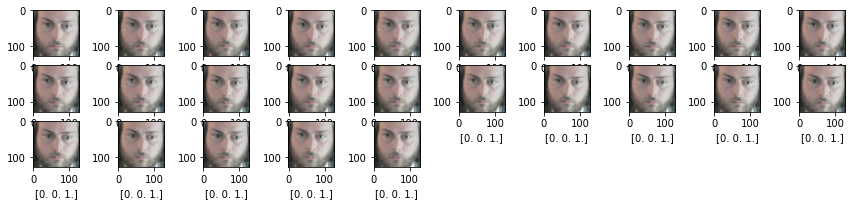

Len train generator:  90
Len val generator:  30
Image Shape:  (3, 25, 128, 128, 3)
Using ConvLSTM2D...
Model: "ConvLSTM2D_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 25, 128, 128, 3)] 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 25, 128, 128, 20)  16640     
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 128, 128, 20)  80        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 25, 64, 64, 20)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 25, 64, 64, 20)    28880     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 64, 64, 20)    80        
_____________

In [ ]:
start_preprocessing()

In [10]:
class DifficultyImageClassifier:
    """
    Custom CNN based on the 3D CNN used in the Fridman Paper for predicting the difficulty level with images of a user's face.
    """

    def __init__(self, num_classes, num_epochs=32):
        self.n_classes = num_classes
        self.n_epochs = num_epochs
        self.num_workers = 8

    def build_model(self, input_shape):
        print("Using Fridman Paper 3D CNN...")
        
        # Model architecture based on https://www.researchgate.net/publication/324658835_Cognitive_Load_Estimation_in_the_Wild
        self.sequential_model = tf.keras.Sequential()
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu', input_shape=(input_shape[1:])))
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
        
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
        
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.Conv3D(128, (3,3,3), activation='relu'))
        self.sequential_model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

        self.sequential_model.add(tf.keras.layers.Flatten())
        self.sequential_model.add(tf.keras.layers.Dense(1024, activation='relu'))
        self.sequential_model.add(tf.keras.layers.Dense(1024, activation='relu'))
        # self.sequential_model.add(tf.keras.layers.Dropout(0.2))
        self.sequential_model.add(tf.keras.layers.Dense(self.n_classes, activation='softmax'))

        self.sequential_model.summary()

        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])
        return self.sequential_model


    def train_classifier(self, train_generator, val_generator):
        self.train_generator = train_generator
        self.validation_generator = val_generator

        lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

        history = self.sequential_model.fit(self.train_generator,
                                            validation_data=self.validation_generator,
                                            # shuffle=False,
                                            use_multiprocessing=False,
                                            workers=self.num_workers,
                                            epochs=self.n_epochs,
                                            initial_epoch=0,
                                            callbacks=[lr_callback],
                                            verbose=1)

        model_path = os.path.join(results_folder, "Difficulty-CNN-TimeSeries-Fridman-Paper.h5")
        self.sequential_model.save(model_path)

        show_result_plot(history, self.n_epochs, metric="categorical_accuracy",
                         output_name="train_history_time_series.png")

        return history

    def evaluate_classifier(self):
        val_loss, val_acc = self.sequential_model.evaluate(self.validation_generator,
                                                           verbose=1)
        print("Validation loss: ", val_loss)
        print("Validation accuracy: ", val_acc * 100)

    def get_label_name_for_index_pos(self, index_pos):
        mask_array = np.zeros(self.n_classes, dtype=int)  # creates this: [0 0 0]
        mask_array[index_pos] = 1  # if index_pos was 0: [1 0 0]
        return DifficultyLevels.get_label_for_encoding(mask_array)

    def predict(self, img_batch, correct_labels):
        predictions = self.sequential_model.predict(img_batch)

        for i, (prediction, correct_label) in enumerate(zip(predictions, correct_labels)):
            score = tf.nn.softmax(prediction)  # TODO use this or prediction?
            print(f"\nPrediction for sequence {i}: {prediction}\nScore: {score})")
            index = np.argmax(score)
            predicted_label = self.get_label_name_for_index_pos(index)
            print(f"Correct label is  \"{DifficultyLevels.get_label_for_encoding(correct_label)}\"")
            print(f"Predicted label was \"{predicted_label}\" with a confidence of {100 * score[index]:.2f} %")

In [11]:
NEW_IMAGE_SIZE = (64, 64)

9 participants used for training: ['participant_3', 'participant_14', 'participant_11', 'participant_4', 'participant_5', 'participant_2', 'participant_7', 'participant_12', 'participant_13']
3 participants used for validation: ['participant_1', 'participant_10', 'participant_6']
Train Data len: 7290)
Validation Data len: 2430)


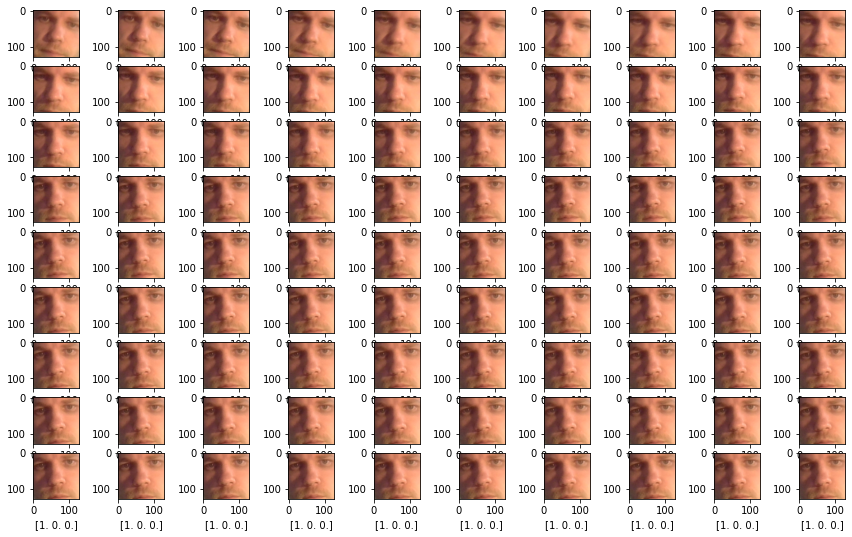

Len train generator:  81
Len val generator:  27
Image Shape:  (1, 90, 128, 128, 3)
Using Fridman Paper 3D CNN...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 88, 126, 126, 128) 10496     
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 86, 124, 124, 128) 442496    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 43, 62, 62, 128)   0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 41, 60, 60, 128)   442496    
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 39, 58, 58, 128)   442496    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 19, 29, 29, 128)   0         
_______

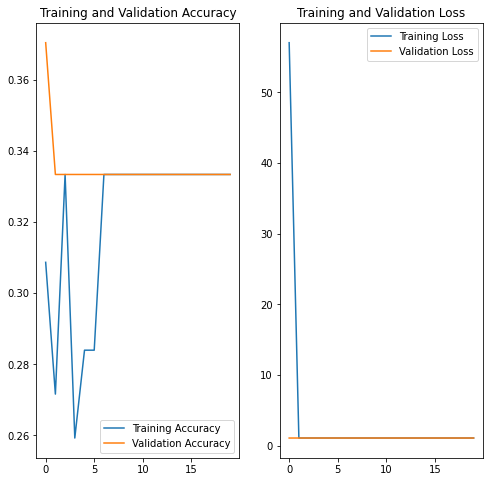

27/27 [==============================] - 17s 610ms/step - loss: 1.0986 - categorical_accuracy: 0.3333
Validation loss:  1.0986424684524536
Validation accuracy:  33.33333432674408


In [16]:
start_preprocessing()

9 participants used for training: ['participant_3', 'participant_14', 'participant_11', 'participant_4', 'participant_5', 'participant_2', 'participant_7', 'participant_12', 'participant_13']
3 participants used for validation: ['participant_1', 'participant_10', 'participant_6']
Train Data len: 7290)
Validation Data len: 2430)
Batch 1:


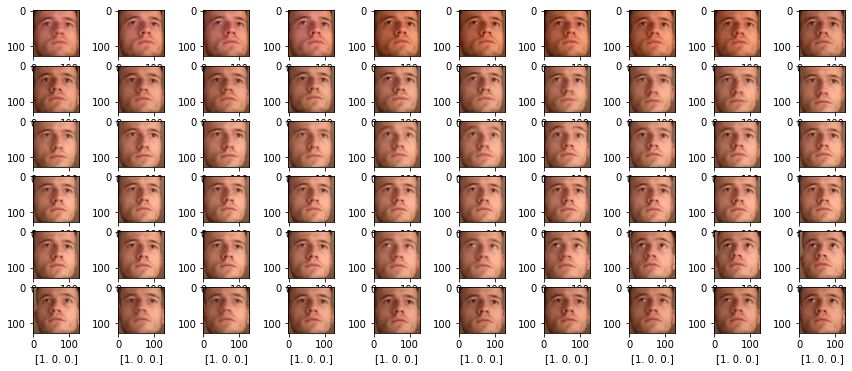

Batch 2:


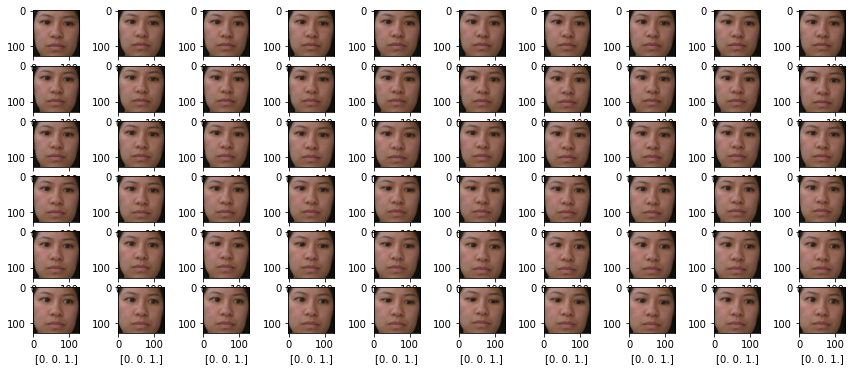

Len train generator:  121
Len val generator:  40
Image Shape:  (1, 60, 128, 128, 3)
Using Fridman Paper 3D CNN...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 58, 126, 126, 128) 10496     
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 56, 124, 124, 128) 442496    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 28, 62, 62, 128)   0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 26, 60, 60, 128)   442496    
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 24, 58, 58, 128)   442496    
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 12, 29, 29, 128)   0         
______

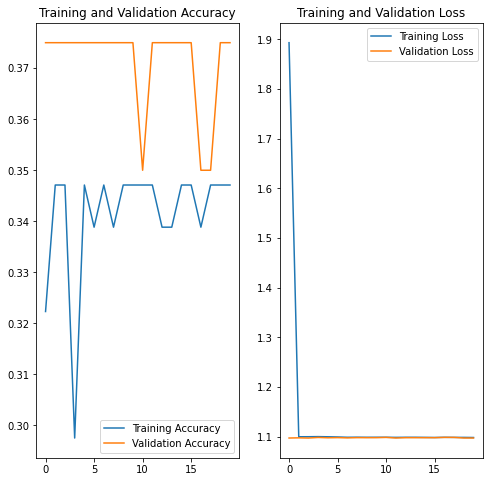

40/40 [==============================] - 20s 481ms/step - loss: 1.0982 - categorical_accuracy: 0.3500
Validation loss:  1.0982152223587036
Validation accuracy:  34.99999940395355


In [18]:
start_preprocessing()